# Dataset Cleaning
This notebook pollutes a train set by randomly flipping labels, then prioritizes train instances
to check and fixes them if they had been flipped.

In [2]:
import os
import sys
sys.path.insert(0, os.getcwd() + '/../')  # for scripts

from scripts.cleaning import noise_detection
data_dir = '../../data'

## Adult

train instances: 32561
test instances: 16281
sum before: 7841
ones flipped: 2998
zeros flipped: 10026
sum after: 14869
num noisy labels: 13024

Before noise:
model (CatBoostClassifier)
train set acc: 0.882590
train log loss: 0.26534
train auroc: 0.937
test set acc: 0.868313
test log loss: 0.28596
test auroc: 0.923

After noise:
model (CatBoostClassifier)
train set acc: 0.607997
train log loss: 0.65584
train auroc: 0.654
test set acc: 0.806277
test log loss: 0.59129
test auroc: 0.826

ordering by our method...


  0%|          | 0/10 [00:00<?, ?it/s]

ordering by random...


  0%|          | 0/10 [00:00<?, ?it/s]

ordering by tree loss...


100%|██████████| 10/10 [00:11<00:00,  1.09s/it]


plotting...


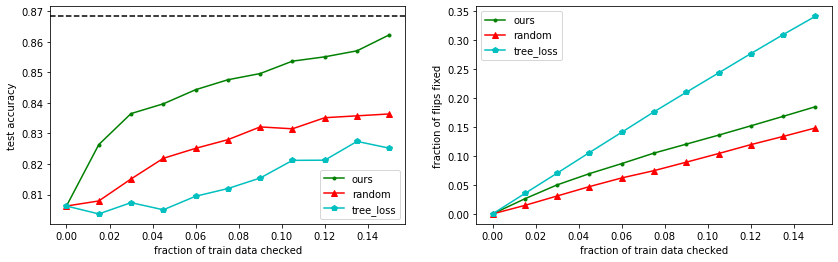

In [9]:
# set inf_k=0 to compare against LeafInfluence
noise_detection(model_type='cb', dataset='adult', flip_frac=0.4,
                linear_model='lr', encoding='leaf_output', kernel='linear',
                random_state=1, data_dir=data_dir, check_pct=0.15,
                inf_k=None)

## Amazon

train instances: 26215
test instances: 6554
sum before: 24711
ones flipped: 9871
zeros flipped: 615
sum after: 15455
num noisy labels: 10486

Before noise:
model (CatBoostClassifier)
train set acc: 0.946176
train log loss: 0.16173
train auroc: 0.873
test set acc: 0.941562
test log loss: 0.18010
test auroc: 0.820

After noise:
model (CatBoostClassifier)
train set acc: 0.619111
train log loss: 0.64896
train auroc: 0.657
test set acc: 0.883583
test log loss: 0.55343
test auroc: 0.547

ordering by our method...


  0%|          | 0/10 [00:00<?, ?it/s]

ordering by random...


  0%|          | 0/10 [00:00<?, ?it/s]

ordering by tree loss...


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


plotting...


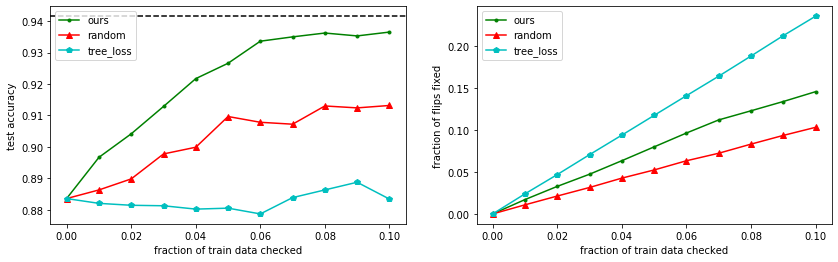

In [6]:
# set inf_k=0 to compare against LeafInfluence
noise_detection(model_type='cb', dataset='amazon', flip_frac=0.4,
                linear_model='lr', encoding='leaf_output', kernel='linear',
                random_state=1, data_dir=data_dir, check_pct=0.1,
                inf_k=None)

## Churn

train instances: 5634
test instances: 1409
sum before: 1495
ones flipped: 592
zeros flipped: 1661
sum after: 2564
num noisy labels: 2253

Before noise:
model (CatBoostClassifier)
train set acc: 0.843983
train log loss: 0.34169
train auroc: 0.905
test set acc: 0.802697
test log loss: 0.43637
test auroc: 0.831

After noise:
model (CatBoostClassifier)
train set acc: 0.701455
train log loss: 0.60570
train auroc: 0.785
test set acc: 0.669979
test log loss: 0.62820
test auroc: 0.662

ordering by our method...


  0%|          | 0/10 [00:00<?, ?it/s]

ordering by random...


  0%|          | 0/10 [00:00<?, ?it/s]

ordering by tree loss...


100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


plotting...


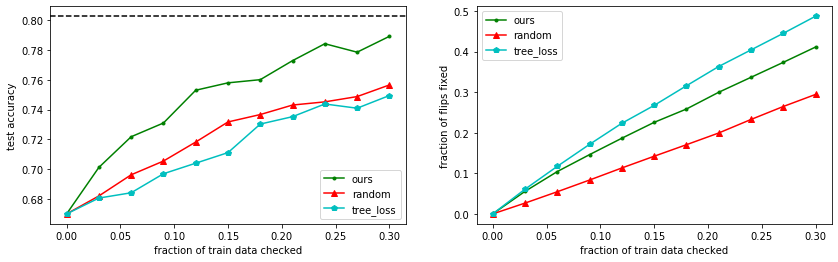

In [8]:
# set inf_k=0 to compare against LeafInfluence
noise_detection(model_type='cb', dataset='churn', flip_frac=0.4,
                linear_model='lr', encoding='leaf_output', kernel='linear',
                random_state=1, data_dir=data_dir, check_pct=0.3,
                inf_k=None)

train instances: 3019
test instances: 755
sum before: 1125
ones flipped: 464
zeros flipped: 743
sum after: 1404
num noisy labels: 1207

Before noise:
model (CatBoostClassifier)
train set acc: 0.995694
train log loss: 0.04125
train auroc: 1.000
test set acc: 0.939073
test log loss: 0.15187
test auroc: 0.985

After noise:
model (CatBoostClassifier)
train set acc: 0.907917
train log loss: 0.41791
train auroc: 0.972
test set acc: 0.743046
test log loss: 0.56405
test auroc: 0.792

ordering by our method...


  0%|          | 0/10 [00:00<?, ?it/s]

ordering by random...


  0%|          | 0/10 [00:00<?, ?it/s]

ordering by tree loss...


100%|██████████| 10/10 [00:19<00:00,  1.86s/it]


plotting...


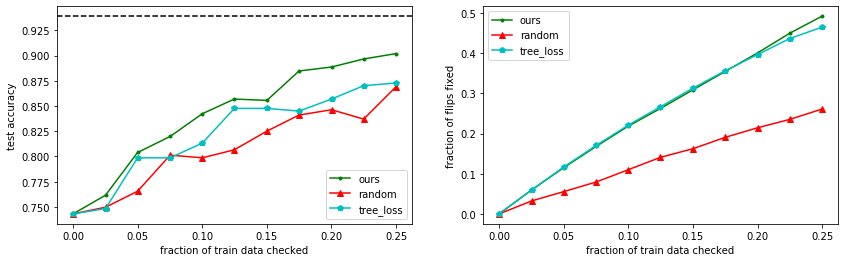

In [11]:
# set inf_k=0 to compare against LeafInfluence
noise_detection(model_type='cb', dataset='NC17_EvalPart1', flip_frac=0.4,
                linear_model='lr', encoding='leaf_output', kernel='linear',
                random_state=1, data_dir=data_dir, check_pct=0.25,
                inf_k=None)